In [120]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cftime
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat

import string
alphabet=list(string.ascii_lowercase)

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

# Read in Data

In [121]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy4'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy4'

case=ctrl

In [122]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-013022_cy5 gzCOBALT-013022_cy5


In [123]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']

# read in files
diagTypes = ['ocean_cobalt_omip_rates_year_z'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]
files=sorted([f for fi in files for f in fi]) # nested list comprehension

int_file = tmpdir + '/'+ 'ocean_cobalt_omip_2d' + '.ann.' + pp_dates + '.nc'

print(files, int_file)

['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5/ocean_cobalt_omip_rates_year_z.1988-2007.nc'] /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5/ocean_cobalt_omip_2d.ann.1988-2007.nc


In [124]:
ds=xr.open_dataset(files[0])
ds_2d = xr.open_dataset(int_file)

grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
grid=xr.open_dataset(grid_file)

In [125]:
# tmpdir = '/work/Jessica.Luo/tmp/'+ctrl['name']
    
# # read in files
# diagTypes = ['ocean_cobalt_omip_rates_year_z'] 

# c_pp_dates='1988-2007'

# c_files=[glob(tmpdir + '/'+ d + '.' + c_pp_dates + '*.nc') for d in diagTypes]
# c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension

# c_int_file = tmpdir + '/'+ 'ocean_cobalt_omip_2d' + '.ann.' + pp_dates + '.nc'

# print(c_int_file, c_files)

In [126]:
# dc=xr.open_dataset(c_files[0])
# dc_2d = xr.open_dataset(c_int_file)

In [127]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

# Calculate export, pe-ratio, transfer efficiency at 500m and 1000m

In [128]:
ds = ds.isel(time=0)
ds_2d = ds_2d.isel(time=0)

In [129]:
print(ds.z_l.values[6], ds.z_l.values[13], ds.z_l.values[18], ds.z_l.values[25])

100.0 500.0 1000.0 2062.5


In [130]:
# this is what Charlie has in his code: Fig15_and_18_export
wgt1 = 1-(2000-ds.z_l.values[24])/(ds.z_l.values[25]-ds.z_l.values[24])
wgt2 = 1-(ds.z_l.values[25]-2000)/(ds.z_l.values[25]-ds.z_l.values[24])

In [131]:
flux100 = ds_2d.epc100
flux500 = ds.expc.sel(z_l=500.)
flux1000 = ds.expc.sel(z_l=1000.)
flux2000 = (ds.expc.isel(z_l=24)*wgt1) + (ds.expc.isel(z_l=25)*wgt2)

In [132]:
ds_2d['flux500']=flux500
ds_2d['flux1000']=flux1000
ds_2d['flux2000']=flux2000

In [133]:
intpp=ds_2d.intpp

In [134]:
val=(flux1000*grid.areacello).sum().values*carbon_molar_mass*seconds_per_year
print('Sequestration flux to 1000m: '+ str(np.round(val/1e15,2)) + ' Pg C/yr')

Sequestration flux to 1000m: 0.84 Pg C/yr


# Read in Observations

In [135]:
import pandas as pd
h19=pd.read_csv('/work/jyl/validation_data/Henson_Data/Henson19_Thdata.csv')
hj=pd.read_csv('/work/jyl/validation_data/Henson_Data/HJflux.csv')

In [136]:
h19 = h19.rename(columns={'Export flux mgC.m2.d':'Flux_100m_mgC.m2.d',
                          'Longitude':'lon',
                          'Latitude':'lat'})

h19 = h19[['lat','lon','Flux_100m_mgC.m2.d']].dropna()
h19

,lat,lon,Flux_100m_mgC.m2.d
0,78.351,-74.317,127.2
1,78.023,-75.847,262.8
2,78.023,-75.847,328.8
3,77.000,-72.652,127.2
4,76.283,-74.388,454.8
...,...,...,...
816,-20.000,-80.000,45.6
817,-20.000,-80.000,172.8
818,-20.000,-100.000,97.2
819,-10.000,-100.000,24.0


In [137]:
hj['Flux_2000m_mgC.m2.d']=hj['Fcorg_at_2km_mmolC.m2.year']*carbon_molar_mass/365.
hj = hj.rename(columns={ 'Longitude':'lon',
                          'Latitude':'lat'})
hj=hj[['lat','lon','Flux_2000m_mgC.m2.d']].dropna()
hj

,lat,lon,Flux_2000m_mgC.m2.d
0,81.0,-138.5,2.895803
1,75.0,150.0,0.493603
2,78.9,1.4,0.756858
3,75.9,11.5,4.014636
4,74.6,-6.7,1.480808
...,...,...,...
129,-63.1,-169.9,3.850101
130,-66.2,-168.7,2.764175
131,-73.5,176.9,0.723951
132,42.2,32.5,8.457060


Text(0.5, 1.0, 'Henson et al. 2019 data points')

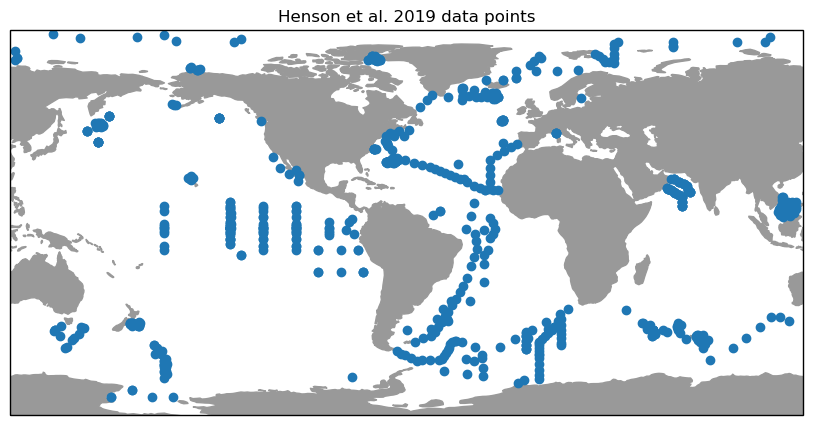

In [138]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=300.))

ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs=ax.scatter(h19.lon, h19.lat, transform=ccrs.PlateCarree())
plt.title('Henson et al. 2019 data points')

Text(0.5, 1.0, 'Honjo et al. 2008 data points')

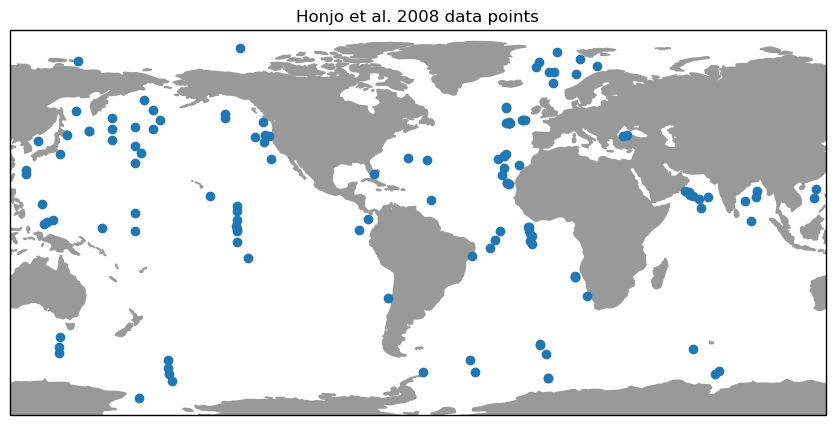

In [139]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=300.0))

ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs=ax.scatter(hj.lon, hj.lat, transform=ccrs.PlateCarree())
plt.title('Honjo et al. 2008 data points')

## Regrid model to observational points

In [140]:
var_keep = ['epc100', 'flux500', 'flux1000', 'flux2000', 'intpp', 'xh', 'yh']
do = ds_2d.drop([v for v in ds_2d.variables if v not in var_keep])
do = do.squeeze(drop=True)
do = do.rename({'xh': 'lon', 'yh': 'lat'})

In [141]:
h19_locs=xr.Dataset()
h19_locs['lon']=xr.DataArray(data=h19.lon.values, dims=('location'))
h19_locs['lat']=xr.DataArray(data=h19.lat.values, dims=('location'))

hj_locs=xr.Dataset()
hj_locs['lon']=xr.DataArray(data=hj.lon.values, dims=('location'))
hj_locs['lat']=xr.DataArray(data=hj.lat.values, dims=('location'))

In [142]:
import xesmf as xe

regridder_h19 = xe.Regridder(do, h19_locs, 'bilinear', locstream_out=True, reuse_weights=True)
regridder_hj = xe.Regridder(do, hj_locs, 'bilinear', locstream_out=True, reuse_weights=True)

Reuse existing file: bilinear_576x720_1x763.nc
Reuse existing file: bilinear_576x720_1x134.nc


In [143]:
ds_h19_rg = regridder_h19(do)
ds_hj_rg = regridder_hj(do)

using dimensions ('lat', 'lon') from data variable intpp as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable intpp as the horizontal dimensions for this dataset.


In [144]:
ds_h19_rg['flux100.mgC.m2.d']=ds_h19_rg.epc100*carbon_molar_mass*1e3*seconds_per_day
ds_hj_rg['flux2000.mgC.m2.d']=ds_hj_rg.flux2000*carbon_molar_mass*1e3*seconds_per_day

## Calculate r and RMSE

In [145]:
from scipy.stats import pearsonr

In [146]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [147]:
model_h19 = ds_h19_rg.to_dataframe()
model_h19 = model_h19[['lat', 'lon','flux100.mgC.m2.d']]
model_h19.reset_index(drop=True)

merged_h19 = pd.merge(h19,model_h19, on=['lat','lon'])
merged_h19 = merged_h19.dropna()

In [148]:
model_hj = ds_hj_rg.to_dataframe()
model_hj = model_hj[['lat', 'lon','flux2000.mgC.m2.d']]
model_hj.reset_index(drop=True)

merged_hj = pd.merge(hj,model_hj, on=['lat','lon'])
merged_hj = merged_hj.dropna()

In [149]:
# Henson et al. 2019
model=merged_h19['flux100.mgC.m2.d']
obs=merged_h19['Flux_100m_mgC.m2.d']
h19_corr = pearsonr(model, obs)[0]
h19_rmse = rmse(model, obs)

print(h19_corr, h19_rmse)

0.18408498417369573 113.39145355681224


In [150]:
# Honjo et al. 2008
model=merged_hj['flux2000.mgC.m2.d']
obs=merged_hj['Flux_2000m_mgC.m2.d']
hj_corr = pearsonr(model, obs)[0]
hj_rmse = rmse(model, obs)

print(hj_corr, hj_rmse)

0.39951000001185116 3.648407717989577


# Plot

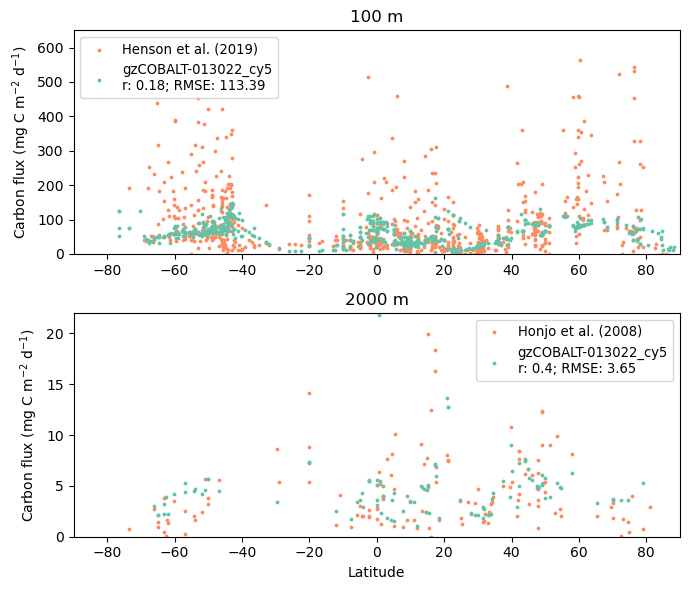

In [151]:
fig=plt.figure(figsize=(7,6))
gs=gridspec.GridSpec(2,1)

alpha=1
size=3
legend_text_size=9.5
color2='#66c2a5'
color1='#fc8d62'

fig.add_subplot(gs[0,0])
plt.ylim([0,650])
plt.xlim([-90,90])
plt.ylabel('Carbon flux (mg C m$^{-2}$ d$^{-1}$)')
plt.scatter(x=h19.lat, y=h19['Flux_100m_mgC.m2.d'], alpha=alpha, s=size, c=color1)
plt.scatter(x=ds_h19_rg.lat.values, y=ds_h19_rg['flux100.mgC.m2.d'].values, alpha=alpha, s=size, c=color2)
plt.legend(['Henson et al. (2019)', 
            fig_casename + '\nr: ' + str(np.round(h19_corr,2)) + '; RMSE: '+str(np.round(h19_rmse,2))],
          prop={'size': legend_text_size})
plt.title('100 m')


fig.add_subplot(gs[1,0])
plt.ylim([0,22])
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Carbon flux (mg C m$^{-2}$ d$^{-1}$)')
plt.scatter(x=hj.lat, y=hj['Flux_2000m_mgC.m2.d'], alpha=alpha, s=size, c=color1)
plt.scatter(x=ds_hj_rg.lat.values, y=ds_hj_rg['flux2000.mgC.m2.d'].values, alpha=alpha, s=size, c=color2)
plt.legend(['Honjo et al. (2008)', 
            fig_casename + '\nr: ' + str(np.round(hj_corr,2)) + '; RMSE: '+str(np.round(hj_rmse,2))],
          prop={'size': legend_text_size})
plt.title('2000 m')

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Export_ModelvsObs.png', dpi=300, bbox_inches='tight')

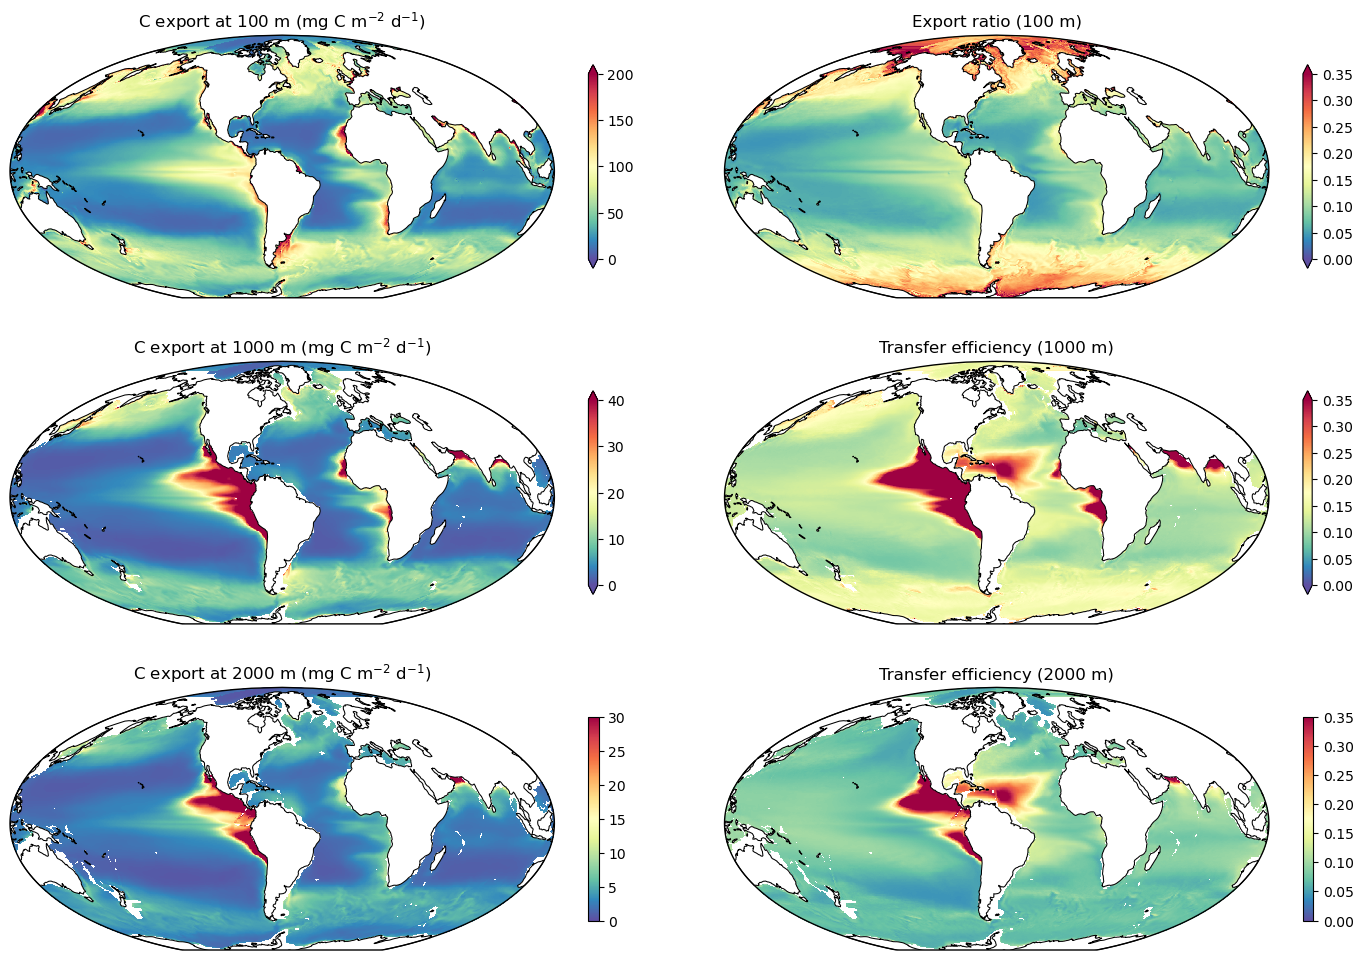

In [152]:
fig=plt.figure(figsize=(18,12))
gs=gridspec.GridSpec(3,2, wspace=0.05, width_ratios=[1,1])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# export at 100 m                                                         #
###########################################################################
cmin = 0; cmax = 200; cint = 10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=flux100*carbon_molar_mass*1e3*seconds_per_day
#cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap='Spectral_r')
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('C export at 100 m (mg C m$^{-2}$ d$^{-1}$)', fontsize=fs)
cbar=plt.colorbar(cs[i], extend='both', shrink=0.75)

cmin = 0; cmax = 0.35; cint = 0.01
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=flux100/intpp
#cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap='Spectral_r')
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Export ratio (100 m)', fontsize=fs)
cbar=plt.colorbar(cs[i], extend='both', shrink=0.75)

###########################################################################
# 1000 m                                                                  #
###########################################################################

cmin = 0; cmax = 40; cint = 1;
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=flux1000*carbon_molar_mass*1e3*seconds_per_day
#cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap='Spectral_r')
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('C export at 1000 m (mg C m$^{-2}$ d$^{-1}$)', fontsize=fs)
cbar=plt.colorbar(cs[i], extend='both', shrink=0.75)

cmin=0; cmax=0.35; cint=0.02
levels=np.arange(cmin,cmax,cint)
i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=flux1000/flux100
#cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap='Spectral_r')
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Transfer efficiency (1000 m)', fontsize=fs)
cbar=plt.colorbar(cs[i], extend='both', shrink=0.75)

###########################################################################
# 2000 m                                                                  #
###########################################################################
cmin = 0; cmax = 30; cint = 1;
levels=np.arange(cmin,cmax,cint)

i=4
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=flux2000*carbon_molar_mass*1e3*seconds_per_day
#cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap='Spectral_r')
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('C export at 2000 m (mg C m$^{-2}$ d$^{-1}$)', fontsize=fs)
cbar=plt.colorbar(cs[i], shrink=0.75)

cmin=0; cmax=0.35; cint=0.02
levels=np.arange(cmin,cmax,cint)
i=5
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=flux2000/flux100
#cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap='Spectral_r')
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Transfer efficiency (2000 m)', fontsize=fs)
cbar=plt.colorbar(cs[i], shrink=0.75)

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_CarbonExport_TransferEfficiency.png', dpi=300, bbox_inches='tight')